In [2]:
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()

import stanza
stanza.download('hu')
nlp = stanza.Pipeline('hu')

import networkx as nx
import numpy as np

2020-07-11 15:36:23 INFO: Downloading default packages for language: hu (Hungarian)...
2020-07-11 15:36:23 INFO: File exists: /mnt/volume/jupyter/stanza_resources/hu/default.zip.
2020-07-11 15:36:27 INFO: Finished downloading models and saved to /mnt/volume/jupyter/stanza_resources.
2020-07-11 15:36:27 INFO: Loading these models for language: hu (Hungarian):
| Processor | Package |
-----------------------
| tokenize  | szeged  |
| pos       | szeged  |
| lemma     | szeged  |
| depparse  | szeged  |

2020-07-11 15:36:27 INFO: Use device: cpu
2020-07-11 15:36:27 INFO: Loading: tokenize
2020-07-11 15:36:27 INFO: Loading: pos
2020-07-11 15:36:29 INFO: Loading: lemma
2020-07-11 15:36:29 INFO: Loading: depparse
2020-07-11 15:36:30 INFO: Done loading processors!


In [3]:
def lemmatize(text):
    if type(text) is float: return text
    doc=nlp(text)
    return ' '.join([word.lemma for word in doc.sentences[0].words])

In [4]:
limit=20

In [5]:
resfiles=glob.glob('resultfiles/*_szokereso_result.csv')
dictstrings = ['person_data', 'wikilist','settlement_list','stanza','szotar_2.1']

In [6]:
res={}
for resfile in resfiles:
    df=pd.read_csv(resfile)
    freqdf = pd.concat([df[col]
                       for dictstring in dictstrings
                       for col in df.columns if dictstring in col]
                       ).value_counts(
                       ).rename_axis('unique_entries_not_lemmatized'
                       ).reset_index(name='counts')
    res[resfile]=freqdf

In [7]:
freqdf=res['resultfiles/data_2020-07-06_06:00:32_szokereso_result.csv']

In [8]:
freqdf['lemmatized']=freqdf.truncate(after=limit)['unique_entries_not_lemmatized'].progress_apply(lemmatize)

100%|██████████| 21/21 [00:01<00:00, 15.45it/s]


In [9]:
freqdf_onlylemmatized = freqdf.\
                        groupby(['lemmatized']).\
                        agg({'counts': 'sum'}).\
                        sort_values(by=['counts'],ascending=False).\
                        reset_index()

In [10]:
cooc = pd.DataFrame(index=freqdf_onlylemmatized['lemmatized'], columns=freqdf_onlylemmatized['lemmatized'])

In [11]:
cooc.index.names =   ['row']
cooc.columns.names = ['column']

In [12]:
df=pd.read_csv('resultfiles/data_2020-07-06_06:00:32_szokereso_result.csv')

In [13]:
dictcols = [col for col in df.columns if any([dictstring in col for dictstring in dictstrings])]

In [14]:
for icoocrow, coocrow in enumerate(cooc.index):
    for icooccol, cooccol in enumerate(cooc.columns):
        if icoocrow ==icooccol: print(icoocrow/limit)
        if icoocrow > icooccol:
            count=0
            for index, row in df[[*dictcols]].iterrows():
                if cooccol in list(row) and coocrow in list(row):
                    count+=1
            cooc.loc[coocrow,cooccol]=count

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


In [15]:
#!!!RUN ONLY ONCE!!!
cooc=cooc.add(cooc.transpose(),fill_value=0)

In [120]:
G=nx.from_numpy_matrix(cooc.fillna(0).to_numpy())

In [121]:
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

In [122]:
import matplotlib.pyplot as plt

In [123]:
mapping={index:each for index, each in enumerate(cooc.columns)}

In [20]:
H = nx.relabel_nodes(G, mapping)

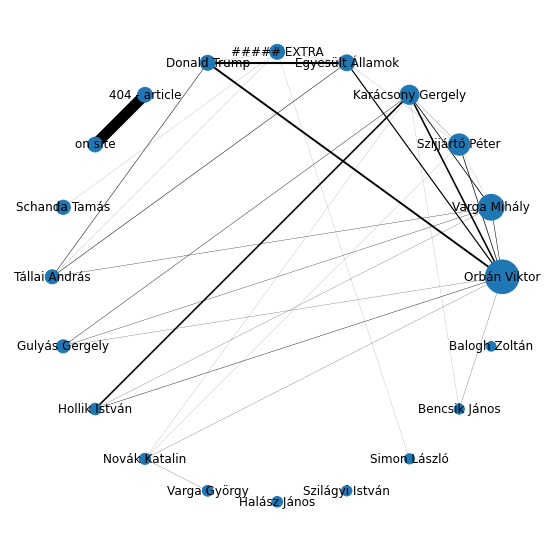

In [21]:
plt.figure(figsize=(7.5,7.5))
wscale=0.1
sscale=2
nx.draw_shell(H,
              with_labels=True,
              width=[weight*wscale for weight in weights],
              node_size=[freqdf_onlylemmatized.set_index('lemmatized').loc[eachperson][0]*sscale
                         for eachperson in H])
plt.margins(0.1,0.1)

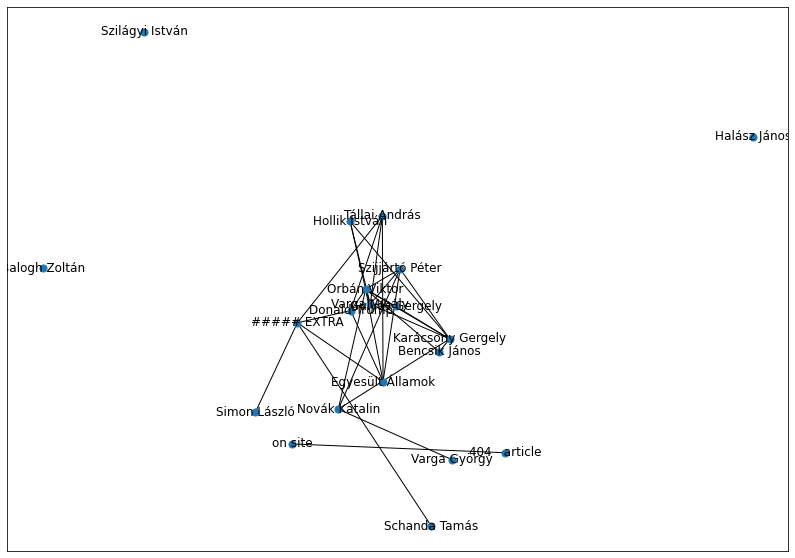

In [85]:
plt.figure(figsize=(14,10))
nx.draw_networkx(H,
                 pos={each:nx.spring_layout(H)[each]*10 for each in nx.spring_layout(H)},
                 weight=weights,
                 node_size=50,
                 k=0.1,
                 iterations=10)

In [2]:
nx.draw(H,
        with_labels=True,
        node_size=50,
        node_color="skyblue",
        pos=nx.spring_layout(H))


NameError: name 'nx' is not defined

In [61]:
nx.spring_layout(H)

{'Orbán Viktor': array([-0.05778509,  0.03273938]),
 'Varga Mihály': array([-0.01038845,  0.04255894]),
 'Szijjártó Péter': array([-0.09675575,  0.0557482 ]),
 'Karácsony Gergely': array([-0.04659641,  0.07226391]),
 'Egyesült Államok': array([-0.04505079, -0.0290392 ]),
 '##### EXTRA': array([-0.03401276, -0.15950821]),
 'Donald Trump': array([-0.050875 , -0.0125702]),
 '404 - article': array([0.32089471, 0.22932229]),
 'on site': array([0.32743683, 0.21522353]),
 'Schanda Tamás': array([ 0.01881639, -0.28412526]),
 'Tállai András': array([-0.00591856, -0.04708829]),
 'Gulyás Gergely': array([0.0146541 , 0.08845446]),
 'Hollik István': array([-0.03721511,  0.10267375]),
 'Novák Katalin': array([-0.13737181,  0.13262755]),
 'Varga György': array([-0.21076046,  0.21245774]),
 'Halász János': array([-0.50590221,  1.        ]),
 'Szilágyi István': array([ 0.76006435, -0.55326636]),
 'Simon László': array([-0.08838196, -0.28471282]),
 'Bencsik János': array([-0.15666381,  0.03670978]),
 'B

In [87]:
G = nx.random_geometric_graph(200, 0.125)

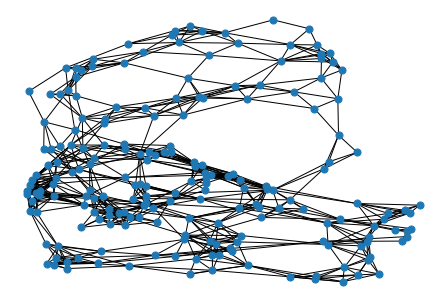

In [91]:
nx.draw(G,node_size=50)

In [92]:
import plotly.graph_objects as go


In [96]:
edge_x = []
edge_y = []
for edge in H.edges():
    x0, y0 = H.nodes[edge[0]]['pos']
    x1, y1 = H.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in H.nodes():
    x, y = H.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

KeyError: 'pos'

In [103]:
H.nodes

NodeView(('Orbán Viktor', 'Varga Mihály', 'Szijjártó Péter', 'Karácsony Gergely', 'Egyesült Államok', '##### EXTRA', 'Donald Trump', '404 - article', 'on site', 'Schanda Tamás', 'Tállai András', 'Gulyás Gergely', 'Hollik István', 'Novák Katalin', 'Varga György', 'Halász János', 'Szilágyi István', 'Simon László', 'Bencsik János', 'Balogh Zoltán'))

In [98]:
G = nx.random_geometric_graph(200, 0.125)


In [107]:
type(G)

networkx.classes.graph.Graph

In [108]:
type(H)

networkx.classes.graph.Graph

In [109]:
H.nodes

NodeView(('Orbán Viktor', 'Varga Mihály', 'Szijjártó Péter', 'Karácsony Gergely', 'Egyesült Államok', '##### EXTRA', 'Donald Trump', '404 - article', 'on site', 'Schanda Tamás', 'Tállai András', 'Gulyás Gergely', 'Hollik István', 'Novák Katalin', 'Varga György', 'Halász János', 'Szilágyi István', 'Simon László', 'Bencsik János', 'Balogh Zoltán'))

In [117]:
pos = nx.get_node_attributes(GG, 'pos')
pos

{}

In [ ]:
GG.set_node_attributes()

In [119]:
list(GG)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]